
# Mean-reversion trading strategy

This is a general template for a quick step by step procedure to create a simple mean-reversion strategy with some explanation.

Pls note go through the code that I am using and their respective repositary in github. 

At the same time, pls bear in mind as a quant researcher, you are fully responsible for your code, strategy and results. 

Henceforth, pls perform necessary due diligence before attempting any form of strategy implementation. Most if not all ideas are from Advances in Financial Machine.

This is strictly for **educational purpose only**, however if done correct may be used for further backtesting.

## Dollar bars

The whole idea of dollar bars is to track cumulative transaction value instead of using standard chronological market price time series. This will be the data structure that we will use.

When it comes to sample dollar bar, it is strongly advised to use dynamic approach to decide bar size. i.e. 10% of average daily transactional volume.

Research reference: [The Volume Clock: Insights into the High Frequency Paradigm](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2034858&rec=1&srcabs=1695596&pos=3)

If you understand the intuition for the above research, you would probably can relate this theory with financial market which supports dollar bars. Otherwise, you can try to see it from behavior finance perspective not just mathematically.

Hence we would need an grounded estimate such as underlying key value/ fundamental drivers that contributes to the total market value/ capitalization until sample size is large enough as close estimate. In the case of commodities and crypto futures, we may resort to production demand and supply, expected growth.

Apply derived estimate to sample dollar bars dynamically to perform normality test and autocorr comparables i.e. Jarque-Bera.

The key objective is to produce samples with better statistical properties hopefully reflecting unimodal, geometric stable distribution. However, striking a balance to prevent losing predictive feature. This can be done using ADF test and how much we need to differentiate as a benchmark.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import timeit

%matplotlib inline

#pls take note of version
#numpy 1.17.3
#pandas 1.0.3
#sklearn 0.21.3

In [16]:
from sklearn.utils import resample
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

from statsmodels.tsa.stattools import adfuller

C:\Users\Wei_X\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [17]:
from mlfinlab.filters import filters
from mlfinlab.features import fracdiff
from mlfinlab.labeling import labeling

from mlfinlab.sampling import concurrent
from mlfinlab.sampling import bootstrapping

from mlfinlab.util import multiprocess
from mlfinlab.util import volatility
from mlfinlab.util import fast_ewma

# It's neither cheap nor easy to do quant research/ development, pls support them.
# If you are a educational organisation or FE students group everyone just needs to donate $1 to pool $10 monthly

In [18]:
# dollar bars sample data, courtesy of mlfinlab, data is sampled every 70,000

dollar = pd.read_csv('./dollar_bars.txt', 
                 sep=',', 
                 header=0, 
                 parse_dates = True, 
                 index_col=['date_time'])

In [19]:
# Reserve memory of initial close
close = dollar['close']
p = print

def data_print(data: pd.DataFrame):
    p('Number of Columns: {0} \nColumns: {1}'.format(len(data.columns), data.columns))
    if 'close' in data.columns:
        p(close.head())
        p(close.describe())
        p('Number of NANs found: {0} \nLast Date: {1}'.format(len(data[close.isna()]), data.iloc[-1].name))
    else:
        p('For consistant result pls use sample data provided')
        
data_print(dollar)

Number of Columns: 7 
Columns: Index(['open', 'high', 'low', 'close', 'cum_vol', 'cum_dollar', 'cum_ticks'], dtype='object')
date_time
2015-01-01 23:00:23.723    2056.75
2015-01-02 07:07:35.156    2064.00
2015-01-02 09:35:57.204    2060.50
2015-01-02 12:59:42.176    2061.00
2015-01-02 14:19:33.847    2063.75
Name: close, dtype: float64
count    24079.000000
mean      2061.126864
std         88.690949
min       1805.750000
25%       2013.750000
50%       2073.250000
75%       2114.250000
max       2272.000000
Name: close, dtype: float64
Number of NANs found: 0 
Last Date: 2016-12-30 21:13:31.990000


## Stationarity

Before we proceed further we will need to calculate and get stationary feature within our data sample.

We will be using this technique call fixed width fractional differentiate found within AFML.

This is actually one of the key feature that mean-reversion rely on, however using the technique provided. 

We reduce the need to do a full differentiate to attain stationarity, allowing us to preserve as much memory as possible.

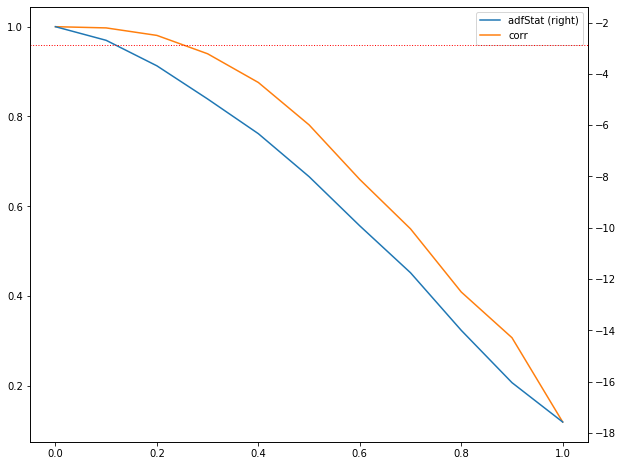

In [20]:
# Code snippet from AFML

fdc = close.to_frame()

def plot_min_ffd(close_prices):
    out = pd.DataFrame(columns=['adfStat', 'pVal', 'lags', 'nObs', '95% conf', 'corr'])
    for d in np.linspace(0, 1, 11):
        df1 = np.log(close_prices[['close']]).resample('1D').last()  # downcast to daily obs        
        df1.dropna(inplace=True)
        df2 = fracdiff.frac_diff_ffd(df1, diff_amt=d, thresh=0.01).dropna()
        corr = np.corrcoef(df1.loc[df2.index, 'close'], df2['close'])[0, 1]
        df2 = adfuller(df2['close'], maxlag=1, regression='c', autolag=None)
        out.loc[d] = list(df2[:4]) + [df2[4]['5%']] + [corr]  # with critical value
    out[['adfStat', 'corr']].plot(secondary_y='adfStat', figsize=(10, 8))
    plt.axhline(out['95% conf'].mean(), linewidth=1, color='r', linestyle='dotted')
    return

plot_min_ffd(fdc)

In [21]:
# based on the above graph, estimated d value is about 0.1176 which is still less than 1

d = 0.1176
log_price = np.log(close).to_frame()

fd_series = fracdiff.frac_diff_ffd(log_price, diff_amt=d)
dollar['fd_series'] = fd_series
dollar.describe()

,open,high,low,close,cum_vol,cum_dollar,cum_ticks,fd_series
count,24079.000000,24079.000000,24079.000000,24079.000000,24079.000000,2.407900e+04,24079.000000,19996.000000
mean,2061.119544,2063.036515,2059.207286,2061.126864,34064.460941,7.007916e+07,4782.275967,2.649688
std,88.684146,88.161108,89.206479,88.690949,1494.343678,1.468380e+05,2752.484944,0.019861
min,1805.500000,1808.000000,1802.500000,1805.750000,30830.000000,7.000000e+07,535.000000,2.568745
25%,2013.750000,2016.000000,2011.500000,2013.750000,33148.000000,7.000528e+07,3189.500000,2.640122
50%,2073.250000,2074.750000,2071.250000,2073.250000,33810.000000,7.002371e+07,3900.000000,2.653689
75%,2114.250000,2115.750000,2112.750000,2114.250000,34786.000000,7.008734e+07,5160.500000,2.662169
max,2272.000000,2273.000000,2271.250000,2272.000000,38929.000000,7.317989e+07,19342.000000,2.692615


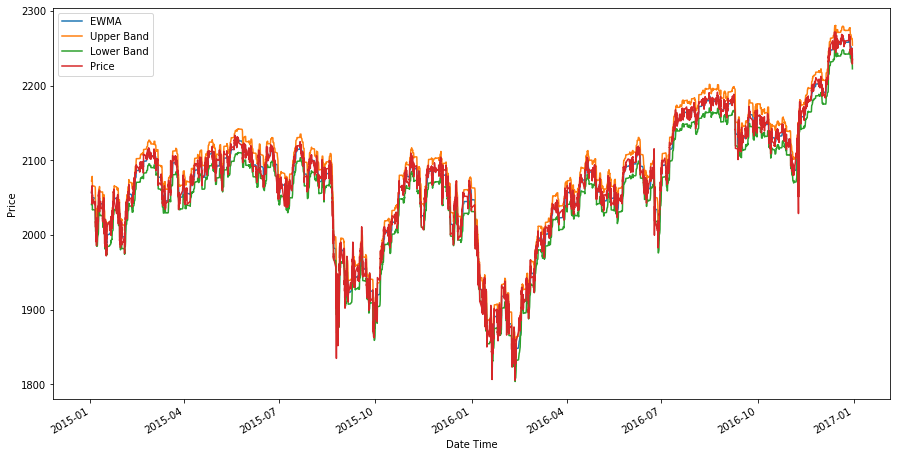

In [22]:
# define a technical indicator boillinger bands
# ewma calculation used may diff from pd.DataFrame.ema()
# This will be used for long short mean-reverting primary model

def bband(data: pd.Series, window: int, width: float):
    '''
    params: pandas Series close price
    params: drift
    params: width of upper/ lower from ewma
    '''
    arr_in = data.to_numpy()
    ema = fast_ewma.ewma(arr_in, window)
    std = ema.std() * width
    _up, _lo = ema + std, ema - std
    
    return ema, _up, _lo
    
# This stage again may require ACF plot since we are producing mean-reverting strategies MA should be significant
dollar['ema'], dollar['upper'], dollar['lower'] = bband(data = close, window = 50, width = 0.18)

x = [dollar['ema'], dollar['upper'], dollar['lower'], close]
_label = ['EWMA', 'Upper Band', 'Lower Band', 'Price']

def multipleplot(periods, labels, xlabel, ylabel):
    periods = periods
    plt.figure(figsize=(15,8))
    for period in periods:
        period.plot()
        continue
    # Plot formatting
    plt.legend(labels)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

multipleplot(periods = x, labels = _label, xlabel = 'Date Time', ylabel = 'Price')

## Primary model setup

Since we are focus on bollinger band as our key technical indicator for mean-reversion strategy.

We need to create an upper, lower boundaries based on moving average. Hence we will use an exponential moving average with certain width away from this average as the upper and lower boundaries.

You may choose an additional indicator to complement bollinger bands.

#### As a trade rule 

If close price is below lower bound it will produce a "Long" signal while if prices are above upper bound it will produce "short" signal.

As core principle of mean-reversion strategy, if prices deviate away from it's average will eventually revert to mean. This is somewhat a contrarian investment if you think deeper.

That is also the reason why up till this stage, we are focus on data structure's statistic properties. It is instrumental to the success of such strategy i.e. low serial correlation, adequate normality score. 

Other strategies types may not such the same process since the theory which support mean-reversion is unique i.e. momentum strategy, volatility strategy.

In [23]:
dollar['side'] = pd.Series(np.nan, dtype = float, index = dollar.index)

for i in np.arange(dollar.index.shape[0] - 1):
    side = dollar['side']
    if (dollar['close'].iloc[i] < dollar['lower'].iloc[i]):
        side.iat[i] = 1
    elif (dollar['close'].iloc[i] > dollar['upper'].iloc[i]):
        side.iat[i] = -1

# Keep an orignal copy just in case    
raw_dollar_bar = dollar.copy()

# Based on our initial bands, total number of long signal will be 1000 and 911 short signals
p(dollar['side'].value_counts())

# Quick check for any NaNs
#p('Total Sum: {0}'.format(dollar.index.shape[0]))

 1.0    1000
-1.0     911
Name: side, dtype: int64


In [24]:
dollar.dropna(inplace = True, how = 'any')
dollar['side'] = dollar['side'].astype(int)
dollar.head(n = 7)

,open,high,low,close,cum_vol,cum_dollar,cum_ticks,fd_series,ema,upper,lower,side
date_time,,,,,,,,,,,,
2015-06-10 15:13:43.498,2099.25,2103.75,2099.25,2103.75,33311,70011566.00,2970,2.660144,2087.421018,2103.260311,2071.581724,-1
2015-06-10 15:14:36.894,2103.75,2106.75,2103.75,2104.50,33250,70002364.00,2398,2.660165,2088.090782,2103.930075,2072.251488,-1
2015-06-10 15:16:54.478,2104.50,2108.00,2104.00,2107.25,33266,70044347.75,2693,2.661249,2088.842124,2104.681417,2073.002830,-1
2015-06-14 22:37:11.327,2085.25,2085.75,2072.00,2073.75,33632,70007556.00,4271,2.646804,2091.150821,2106.990115,2075.311528,1
2015-06-15 12:50:16.247,2074.75,2076.00,2072.25,2073.00,33762,70023952.50,4581,2.647528,2088.939067,2104.778360,2073.099773,1
2015-06-15 13:30:00.132,2072.75,2073.25,2070.00,2071.50,33839,70098007.75,4010,2.647056,2088.255182,2104.094475,2072.415888,1
2015-06-15 13:31:35.521,2071.50,2071.75,2066.50,2066.75,33838,70001953.25,3375,2.645004,2087.411841,2103.251135,2071.572548,1


## Adding filters to strategy

For consistancy, we will continue to use 50 Days EMA standard deviation to filter any signals that are outside the upper and lower bands.

This step is necessary to get triggered signals at their respective points.

We will only use single value point of estimate for our threshold. At the same time, it will also increase your accuracy during random forest training.

One thing to note when applying symmetrical cusum filter, using absolute return can produce least heteroskedasticity. 

Another interesting fact about using percentage return, it is highly likely that it has weak evidence for stationarity but it may not possess predictive power for machine learning.

In [25]:
daily_vol = volatility.get_daily_vol(close = dollar['close'], lookback = 50)
threshold = daily_vol.mean() * 0.1

cusum_events = filters.cusum_filter(raw_time_series = dollar['close'], 
                                    threshold = threshold)

# p('Threshold for daily volatility: {0:.6f}'.format(threshold))
# p('Percentage of sample data after filtered: {0:.2f}%'.format(len(cusum_events)/dollar['close'].count() * 100))

## Using triple barrier method

This is to ensure that when there is an upper limit (Take profit), lower limit (Stop loss) and time constraint.

Where vertical barriers represents the time constraint.

As my hypothesis, such time contraint could be adjusted with other key factors i.e. overall market liquidity

However do take note of cutoff time for respective exchange during implementation especially if spread/ pair strategy.

#### Vertical Barrier

Time constraint will be applied, this is to ensure we do not wait beyond a certain point. Vertical barriers are subjective. 

In Market where prices change are not frequent (Prices can stay within range above 1 month), this barrier should be used.

#### Minimum requirement

Using daily volatility may introduce more noise otherwise less consistence, however we can only confirm this with white test.

Therefore an average daily volatility over a certain period as an estimate will be used. Moreover, we will need to know which transaction can profit above average over this period.

The daily volatility code snippet provided by AFML updated by mlfinlab (stable release: pandas 1.0.3) removed the first day (reduce look ahead bias), apart from using the daily volatility as cusum filter estimate it will also be used as a target for meta-labeling.

Meta-labels will indicate which event that was triggered by primary model were profitable.

In [26]:
#Take note dollar['close'] is different from defined variable 'close'

vertical_barriers = labeling.add_vertical_barrier(t_events = cusum_events, 
                                                  close = close, 
                                                  num_days = 5)

#profit taking and stop loss is symmetrical with no additional multipler to increase their spread
pt_sl = [1, 1]

# min requirement has to be lower than daily volatility 
min_ret = 0.0015

# Standardize num of threads that we will be using
num_threads = 3

#This may take sometime, even with multiprocess built-in
triple_barrier_events = labeling.get_events(close = close,
                                            t_events = cusum_events,
                                            pt_sl = pt_sl,
                                            target = daily_vol,
                                            min_ret = min_ret,
                                            num_threads = num_threads,
                                            vertical_barrier_times = vertical_barriers,
                                            side_prediction = dollar['side'])


2020-05-03 11:29:34.385287 100.0% apply_pt_sl_on_t1 done after 0.12 minutes. Remaining 0.0 minutes.


## Concurrency

After we derived our primary model and secondary model output, we need to know how many of such labels may have overlapped. Even more so if there is no vertical barrier invoked.

This stage is often neglected especially as a beginner when you just started performing quantitative research.

Concurrency may seem harmless at a glance, but during ensemble stage having concurrent sample data from primary and secondary model will increase OOB score significantly.

Kindly go through the tutorial notebook for quick explanation: [Concurrency implication](https://github.com/boyboi86/research/blob/master/Tutorial/Concurrency.ipynb)

In short, if you are wrong the machine will endorse your mistakes.

To counter this problem, we will first need to know how uniqueness of each label.

In [29]:
idx_matrix = bootstrapping.get_ind_matrix(triple_barrier_events, close)



In [30]:
av_idx_unique = bootstrapping.get_ind_mat_average_uniqueness(idx_matrix)

In [35]:
# Enhance sample using sequential bootstrapping

samples = bootstrapping.seq_bootstrap(idx_matrix, 
                                      compare = True, 
                                      sample_length = 50, 
                                      warmup_samples=[1], 
                                      verbose=False)

Standard uniqueness: 0.7065928535480624
Sequential uniqueness: 0.8522594240224771


## Random forest

After this step, we will have to start to fit a random forest. Using sequential bootstrap method, for OOB scoring.

That is all for now, as for random forest you may wish to refer to sklearn. 

Just take note of the first 4 portion.

Step 1: Restructure data

Step 2: Attain Stationarity via ffd

Step 3: Set up primary model

Step 4: Triple barrier implementation (Secondary model)

Step 5: Sequential bootstrap for random forest. Do not use random forest random sample.